# Flag detection analysis

The purpose of this jupyter notebook is to:
* visualize data which the following flags are based on: _hovering, cloud, pollution_;
* visualize available manually created flags;
* based on the manually created flags, find the best parameters for the flag detection algorithm to later use those parameters for the automatic creation of flags.

In [1]:
%load_ext autoreload
%autoreload 2

## Load data

In [2]:
from helikite.constants import constants

# specify the directories containing the data
level2_dir_relpaths = [
    "ORACLES/Helikite/2024-2025/Data/Processed/Level2",
    "Turtmann/data/Helikite/Processing/Level2",
]
level2_dir_abspaths = [constants.DATA_DIRPATH / relpath for relpath in level2_dir_relpaths]

# specify the data columns and the corresponding flag columns
columns_to_flags = {
    "Altitude": "flag_hovering",
    "mCDA_total_N": "flag_cloud",
    "CPC_total_N": "flag_pollution",
}

In [3]:
import os
import pandas as pd

# load all data into a single dataframe
dfs = []
all_columns = list(columns_to_flags.keys()) + list(columns_to_flags.values())

for dirpath in level2_dir_abspaths:
    for filename in os.listdir(dirpath):
        if not filename.endswith(".csv"):
            continue

        filepath = dirpath / filename

        dtype = {c: "Float64" for c in columns_to_flags.keys()} | {c: "boolean" for c in columns_to_flags.values()}
        df = pd.read_csv(filepath, index_col="datetime", parse_dates=["datetime"], dtype=dtype)

        for col in all_columns:
            if col not in df.columns:
                df[col] = pd.Series(dtype=dtype[col])

        dfs.append(df[all_columns])

df = pd.concat(dfs)
df.sort_index(inplace=True)
df = df[~df.index.duplicated(keep="first")]

In [4]:
from helikite.processing.post.fda import FDA, FDAParameters

## Plot data
### Plot 2D histogram and time series
There are two 2D histograms in the plots (a):
1) _blue:_ all observations;
2) _light yellow:_ observations with a manual flag equal to 1.

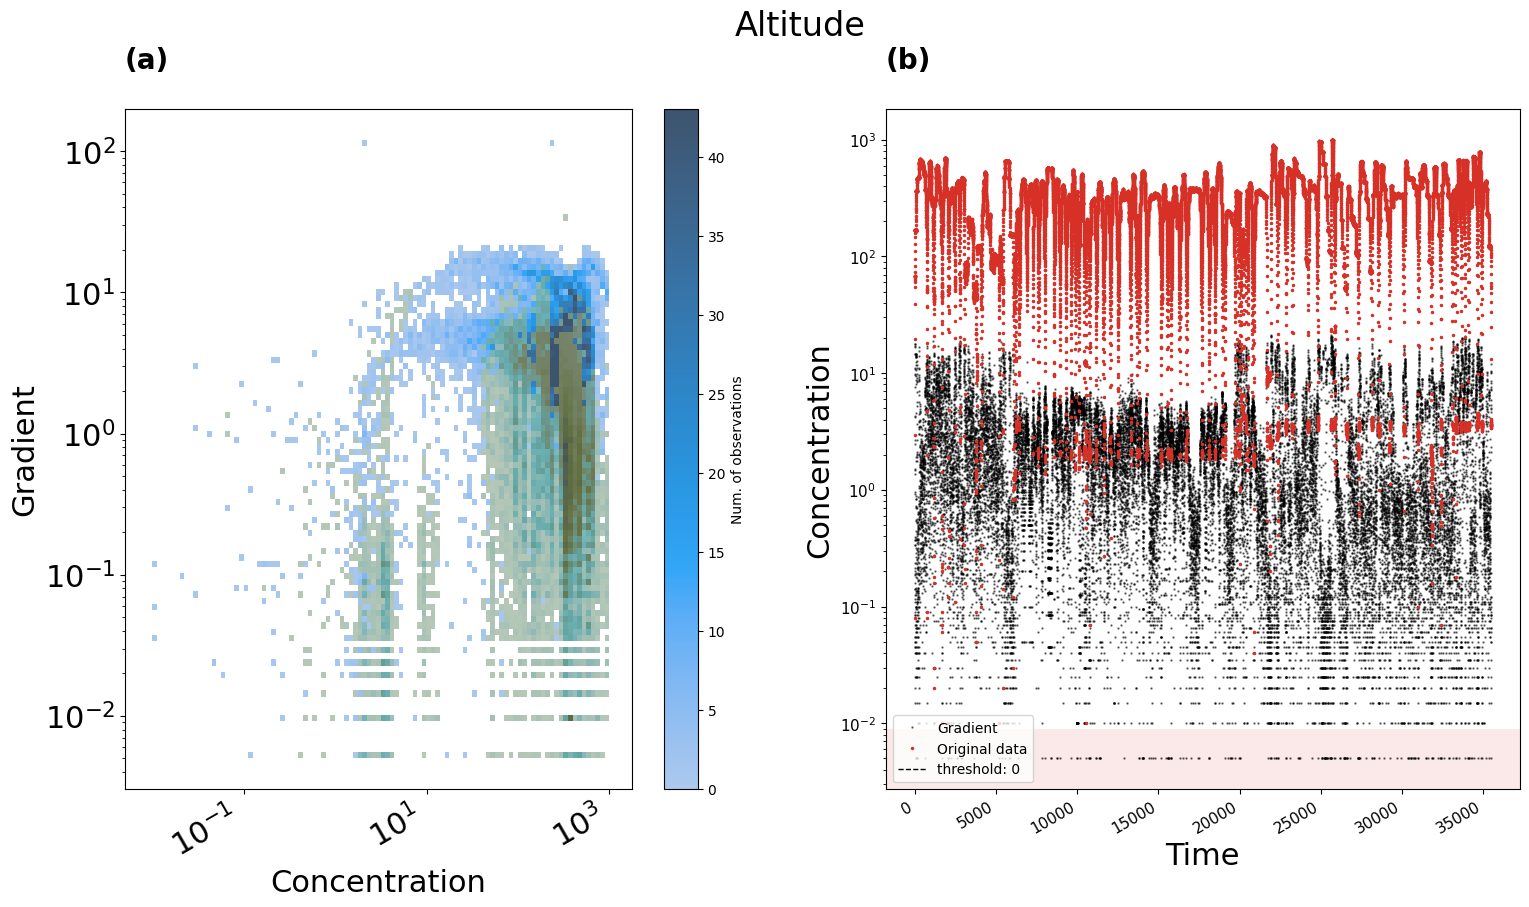

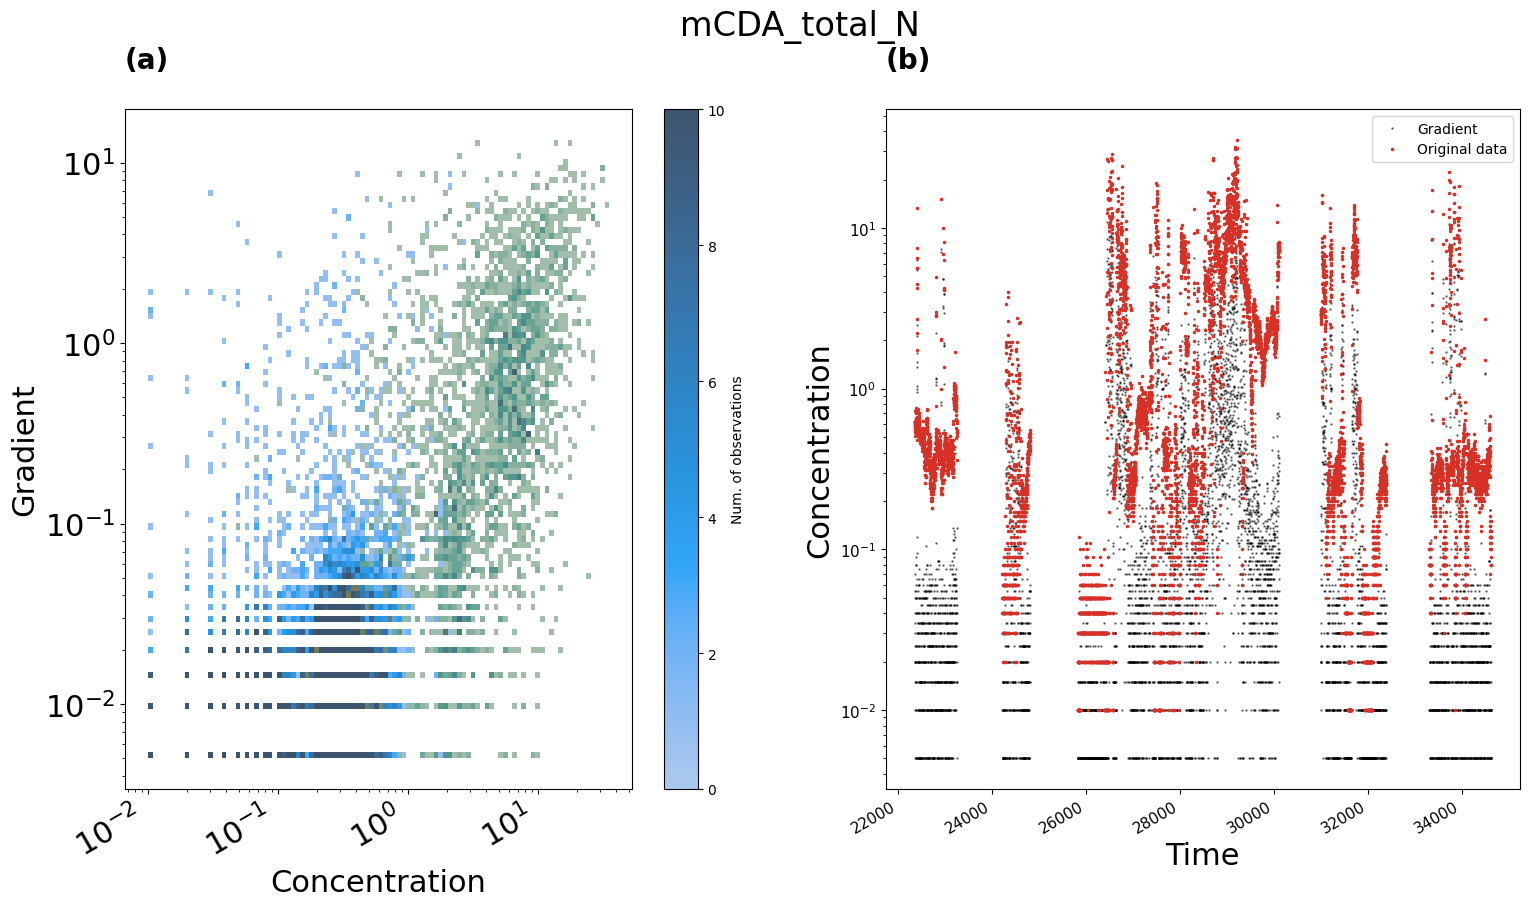

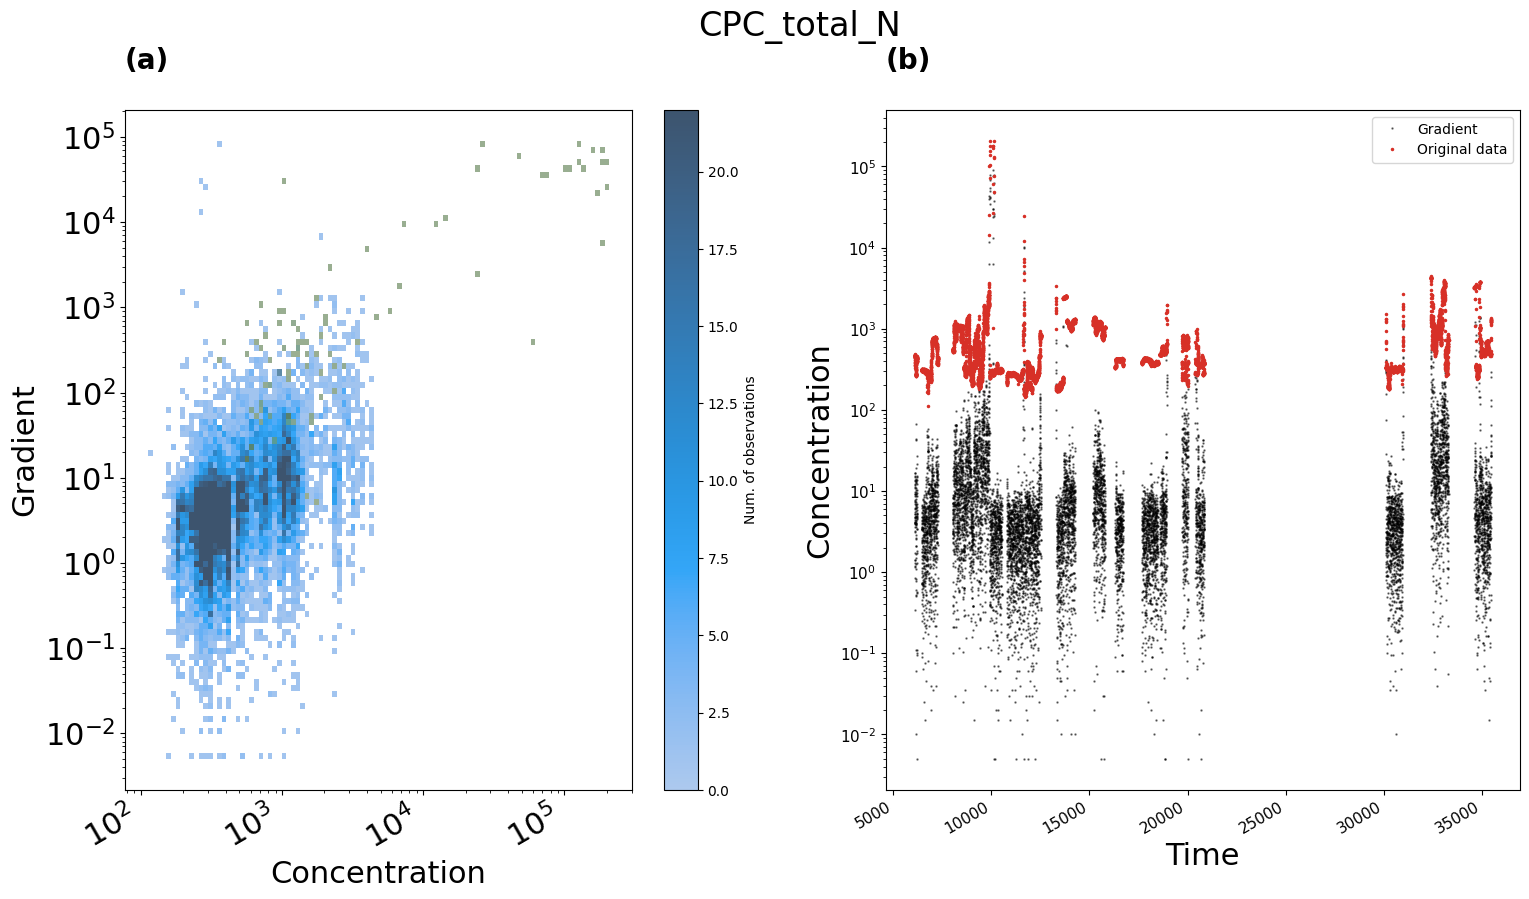

In [5]:
for col, flag_col in columns_to_flags.items():
    fda = FDA(df, col, flag_col, FDAParameters(inverse=flag_col == "flag_hovering"))
    fda.plot_data(use_time_index=False)

### Plot 2D histogram and time series with thresholds

Try defining thresholds and see them on the histogram plots.
In 2D histogram, observations in the areas shaded with red color:
* _vertical:_ will be filtered out by the main filter;
* _horizontal:_ will be filtered out by the main filter in case `power_law` main filter is used;

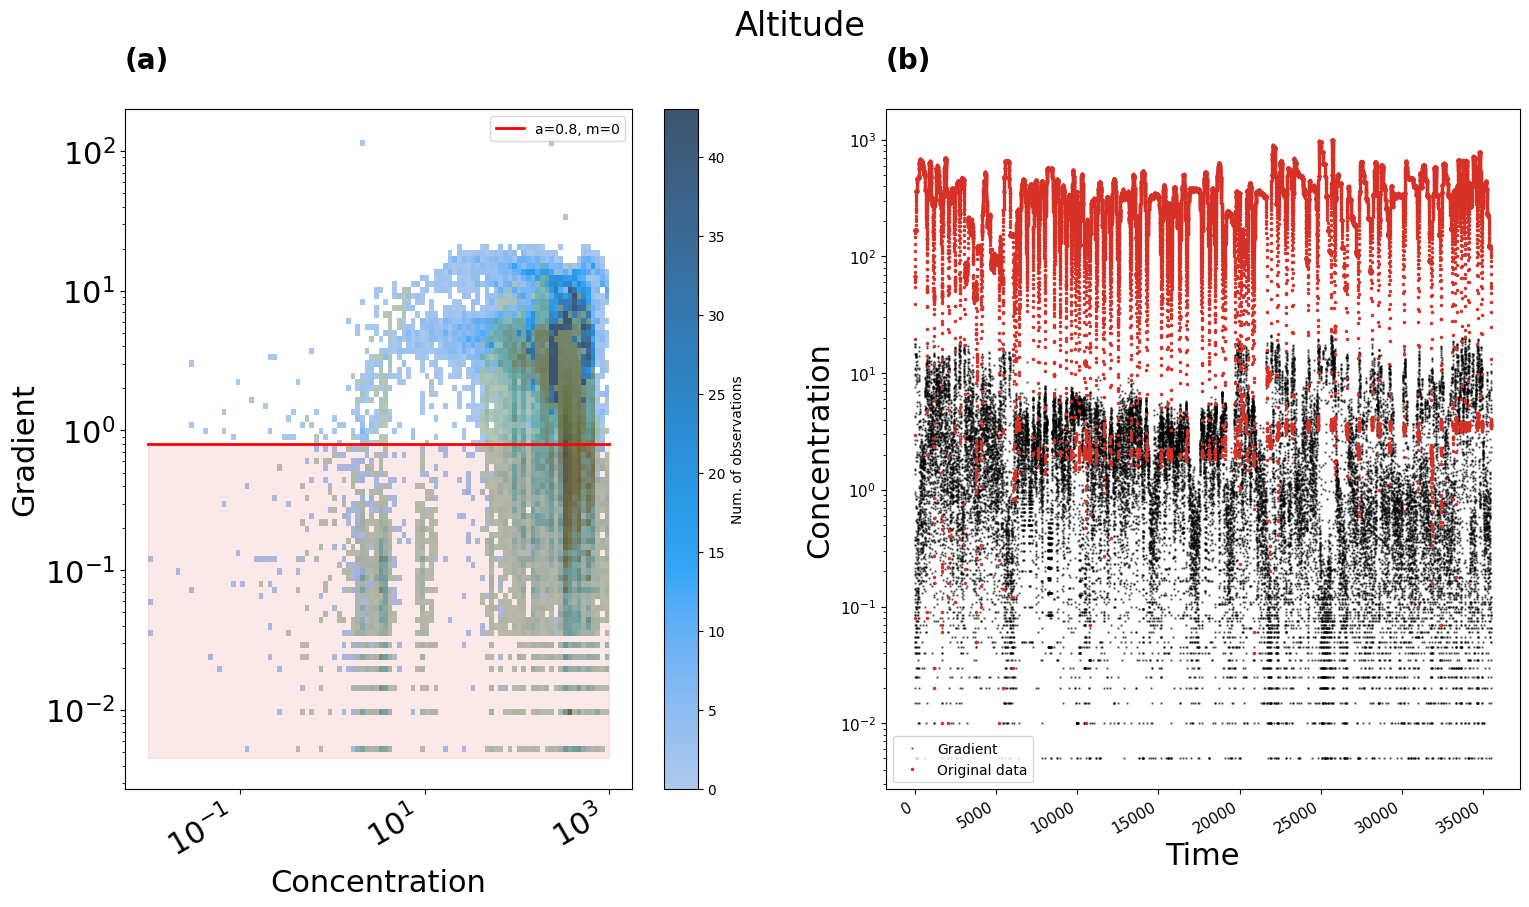

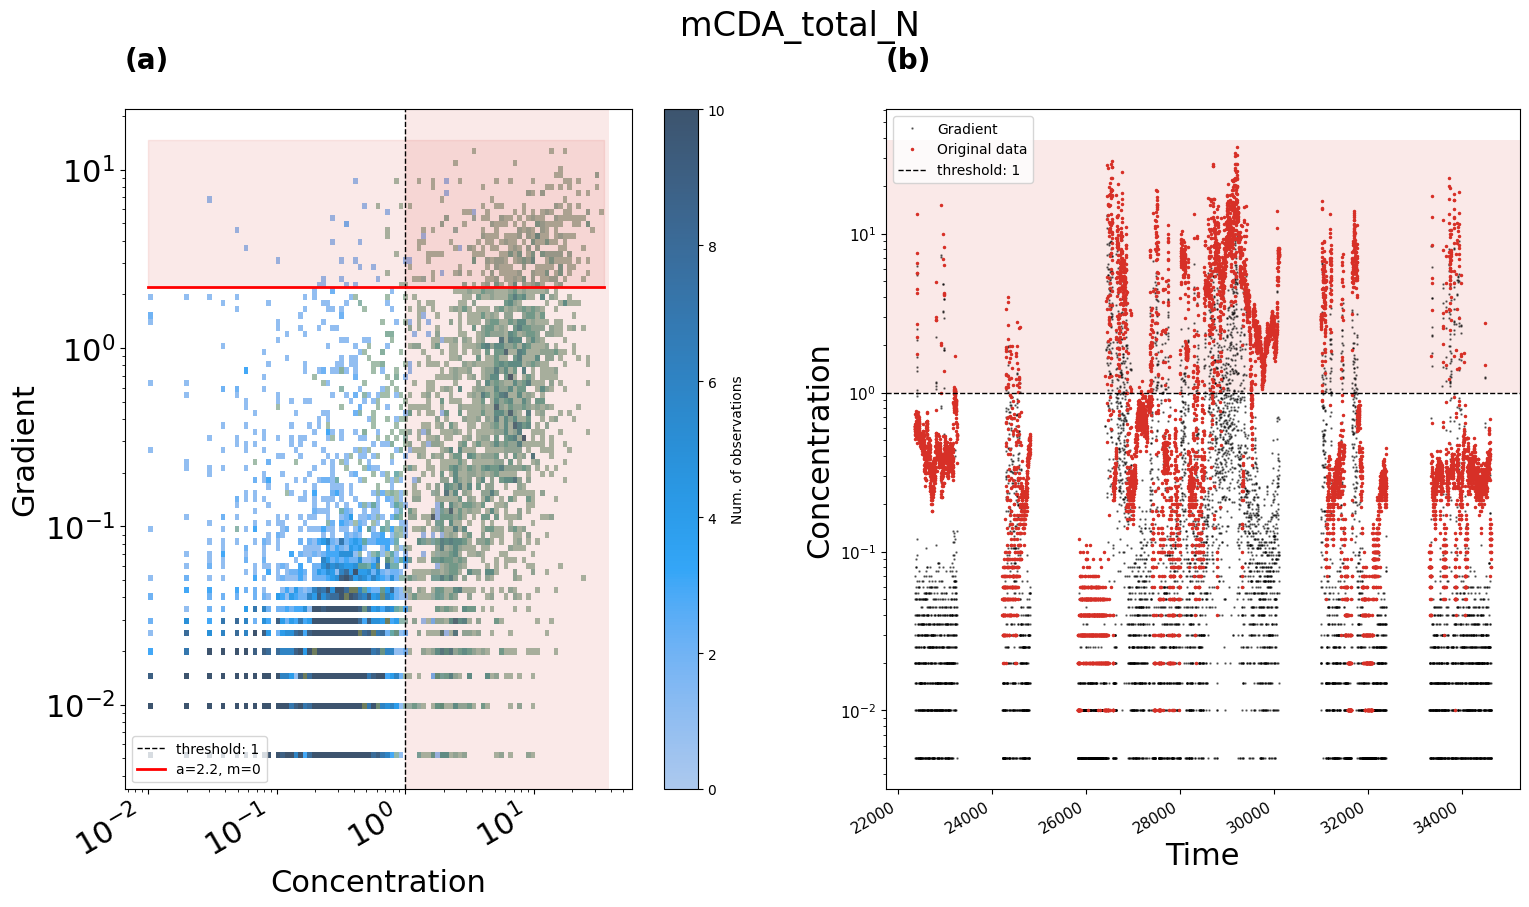

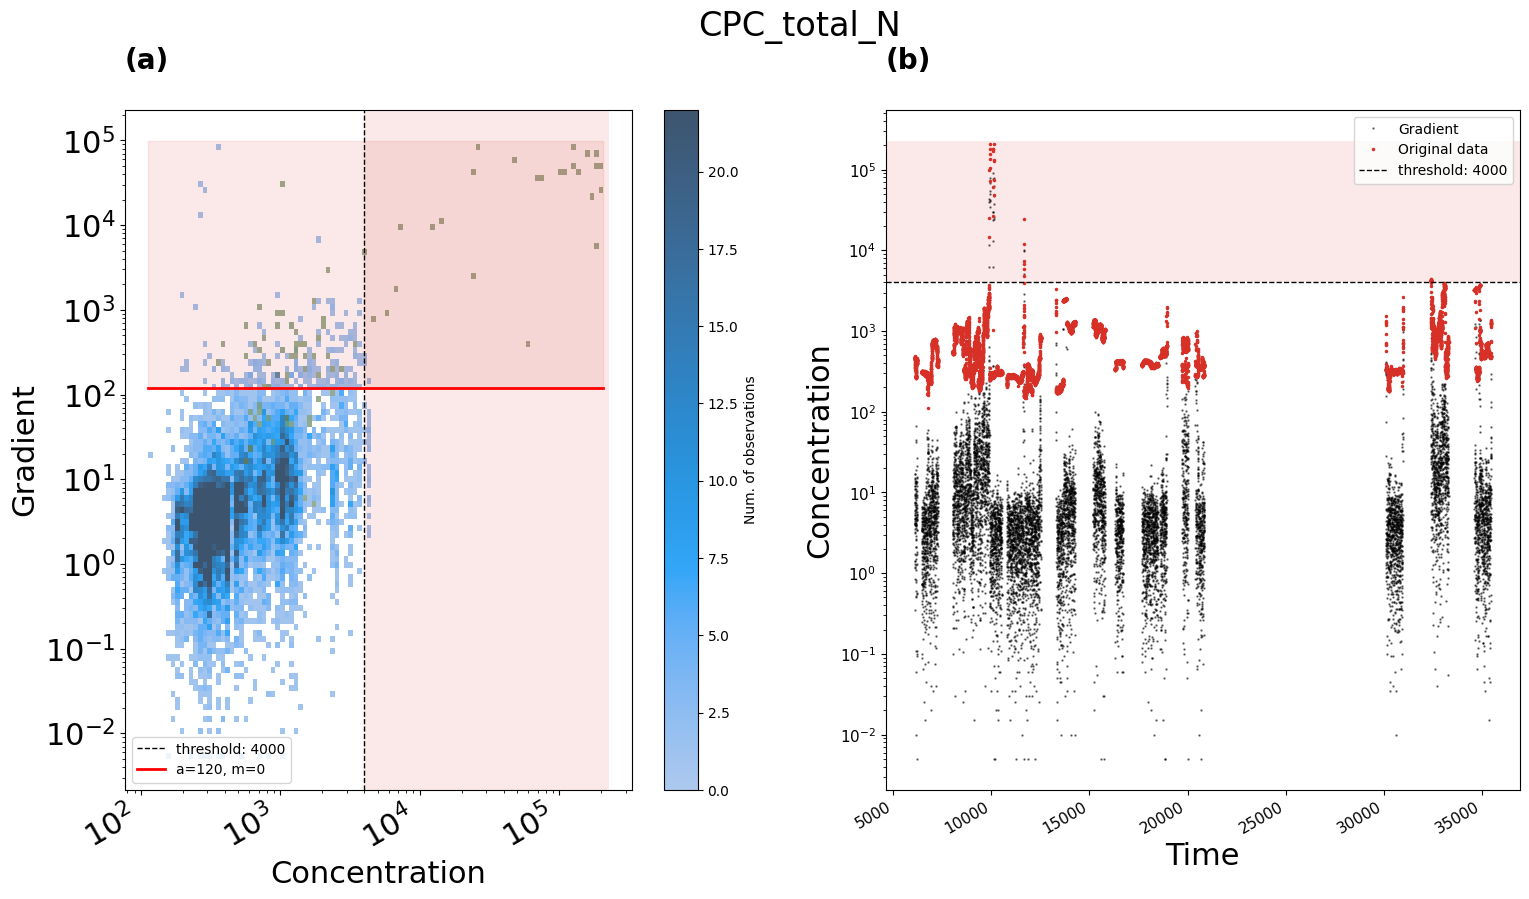

In [6]:
import numpy as np

params = {
    "Altitude": FDAParameters(
        inverse=True,
        lower_thr=-np.inf,
        pl_a=0.8,
        pl_m=0,
    ),
    "mCDA_total_N": FDAParameters(
        inverse=False,
        lower_thr=0,
        upper_thr=1,
        pl_a=2.2,
        pl_m=0,
    ),
    "CPC_total_N": FDAParameters(
        inverse=False,
        lower_thr=0,
        upper_thr=4000,
        pl_a=120,
        pl_m=0,
    ),
}

for col, flag_col in columns_to_flags.items():
    fda = FDA(df, col, flag_col, params[col])
    fda.plot_data(use_time_index=False)

## Find the best parameters using grid search
In the following cells, define the values of the paramaters to try.
The best parameters will be chosen using grid search.
See documentation for `helikite.processing.post.fda.FDA` to better understand what each parameter does.

In [7]:
import itertools
import dataclasses

def find_best_params(df: pd.DataFrame, column: str, flag_column: str, base_params: FDAParameters, grid: dict[str, list[float]]):
    assert (~df[flag_column].isna()).any(), f"No ground truth (manually specified) values for {flag_column} available"

    best_f1 = 0
    best_params = None

    for values in itertools.product(*grid.values()):
        params = dataclasses.replace(base_params, **dict(zip(grid.keys(), values)))

        fda = FDA(df, column, flag_column, params)
        flag = fda.detect_pollution()

        f1 = FDA.evaluate(df[column], flag, df[flag_column], verbose=False)

        if f1 > best_f1:
            best_f1 = f1
            best_params = params

    print(f"Best params with f1 score {best_f1}: {best_params}")

    fda = FDA(df, column, flag_column, best_params)
    flag = fda.detect_pollution()
    _ = FDA.evaluate(df[column], flag, df[flag_column], verbose=True)

    return best_params, best_f1

The same parameter grid is used for secondary filters, i.e. neighbor, median, and sparse filters.
Try changing the parameter grid in the cell below, or directly specify secondary filter parameters in the cells that follow, where for each flag grid search is launched.

In [8]:
import numpy as np

best_params = {}

grid_secondary_filters = {
    "use_neighbor_filter": [True, False],
    "use_median_filter": [True],
    "use_sparse_filter": [True],
    "median_window": ["1min", "2min"],
    "median_factor": [2.0, 4.0, np.inf],
    "sparse_window": [30],
    "sparse_thr": [26, 28, 30],
}

In [9]:
# specify main filter parameters for hovering detection
column = "Altitude"
flag_column = columns_to_flags[column]

base_params = FDAParameters(
    inverse=True,
    avg_time="5s",
)

grid_iqr = {
    "main_filter": ["iqr"],
    "iqr_window": ["32min", "64min", "128min"],
    "iqr_factor": [-1.6, -0.8, -0.4],
}

grid_pl = {
    "main_filter": ["power_law"],
    "pl_a": [0.4, 0.8, 1.0],
}

best_params_iqr, f1_iqr = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_iqr)
best_params_pl, f1_pl = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_pl)

best_params[column] = best_params_pl if f1_iqr < f1_pl else best_params_iqr

Best params with f1 score 0.7060679474899995: FDAParameters(inverse=True, avg_time='5s', main_filter='iqr', use_neighbor_filter=True, use_median_filter=True, use_sparse_filter=True, pl_a=inf, pl_m=0, iqr_window='128min', iqr_factor=-0.8, lower_thr=0, upper_thr=inf, median_window='1min', median_factor=2.0, sparse_window=30, sparse_thr=26)
TP = 12532
FP = 8491
TN = 12507
FN = 1943
Precision = 0.5961090234505065
Recall = 0.8657685664939551
F1 = 0.7060679474899995
Best params with f1 score 0.7803418276053558: FDAParameters(inverse=True, avg_time='5s', main_filter='power_law', use_neighbor_filter=True, use_median_filter=True, use_sparse_filter=True, pl_a=0.8, pl_m=0, iqr_window=None, iqr_factor=None, lower_thr=0, upper_thr=inf, median_window='1min', median_factor=2.0, sparse_window=30, sparse_thr=28)
TP = 12647
FP = 5292
TN = 15704
FN = 1828
Precision = 0.7050002787223368
Recall = 0.873713298791019
F1 = 0.7803418276053558


In [10]:
# specify main filter parameters for cloud detection
column = "mCDA_total_N"
flag_column = columns_to_flags[column]

base_params = FDAParameters(
    inverse=False,
    avg_time="5s",
)

grid_iqr = {
    "main_filter": ["iqr"],
    "upper_thr": [0.8, 1, 1.2],
    "iqr_window": ["32min", "64min", "128min"],
    "iqr_factor": [-0.4, -0.2, 0.0, 0.2],
}

grid_pl = {
    "main_filter": ["power_law"],
    "upper_thr": [0.8, 1, 1.2],
    "pl_a": [1.8, 2.0, 2.2],
}

best_params_iqr, f1_iqr = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_iqr)
best_params_pl, f1_pl = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_pl)

best_params[column] = best_params_pl if f1_iqr < f1_pl else best_params_iqr

Best params with f1 score 0.8543753078312265: FDAParameters(inverse=False, avg_time='5s', main_filter='iqr', use_neighbor_filter=False, use_median_filter=True, use_sparse_filter=True, pl_a=inf, pl_m=0, iqr_window='128min', iqr_factor=0.2, lower_thr=0, upper_thr=1, median_window='1min', median_factor=inf, sparse_window=30, sparse_thr=30)
TP = 2602
FP = 801
TN = 4976
FN = 86
Precision = 0.76461945342345
Recall = 0.9680059523809523
F1 = 0.8543753078312265
Best params with f1 score 0.9486798066195612: FDAParameters(inverse=False, avg_time='5s', main_filter='power_law', use_neighbor_filter=False, use_median_filter=True, use_sparse_filter=True, pl_a=2.2, pl_m=0, iqr_window=None, iqr_factor=None, lower_thr=0, upper_thr=1, median_window='2min', median_factor=4.0, sparse_window=30, sparse_thr=30)
TP = 2551
FP = 139
TN = 5635
FN = 137
Precision = 0.9483271375464684
Recall = 0.9490327380952381
F1 = 0.9486798066195612


In [11]:
# specify main filter parameters for pollution detection
column = "CPC_total_N"
flag_column = columns_to_flags[column]

base_params = FDAParameters(
    inverse=False,
    avg_time="5s",
)

grid_iqr = {
    "main_filter": ["iqr"],
    "upper_thr": [0.6, 0.8, 1],
    "iqr_window": ["1min", "4min", "16min", "64min"],
    "iqr_factor": [-3.2 -1.6, -0.8],
}

grid_pl = {
    "main_filter": ["power_law"],
    "upper_thr": [2000, 3000, 4000],
    "pl_a": [30, 60, 120]
}

best_params_iqr, f1_iqr = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_iqr)
best_params_pl, f1_pl = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_pl)

best_params[column] = best_params_pl if f1_iqr < f1_pl else best_params_iqr

Best params with f1 score 0.01842353187480373: FDAParameters(inverse=False, avg_time='5s', main_filter='iqr', use_neighbor_filter=True, use_median_filter=True, use_sparse_filter=True, pl_a=inf, pl_m=0, iqr_window='1min', iqr_factor=-4.800000000000001, lower_thr=0, upper_thr=0.6, median_window='1min', median_factor=2.0, sparse_window=30, sparse_thr=26)
TP = 88
FP = 9377
TN = 0
FN = 0
Precision = 0.009297411516111992
Recall = 1.0
F1 = 0.01842353187480373
Best params with f1 score 0.38823529411764707: FDAParameters(inverse=False, avg_time='5s', main_filter='power_law', use_neighbor_filter=False, use_median_filter=True, use_sparse_filter=True, pl_a=120, pl_m=0, iqr_window=None, iqr_factor=None, lower_thr=0, upper_thr=4000, median_window='1min', median_factor=2.0, sparse_window=30, sparse_thr=30)
TP = 66
FP = 189
TN = 9166
FN = 19
Precision = 0.25882352941176473
Recall = 0.7764705882352941
F1 = 0.38823529411764707


## Plot detection results with the best parameters
After grid search was launched, and for every type of data the best parameters were saved, plot detection results for the parameters found.

In [12]:
for col, ps in best_params.items():
    if ps.use_median_filter and not np.isfinite(ps.median_factor):
        ps.use_median_filter = False
    if ps.use_sparse_filter and ps.sparse_window == ps.sparse_thr:
        ps.use_sparse_filter = False

fda parameters used for Altitude:
{'inverse': True,
 'avg_time': '5s',
 'main_filter': 'power_law',
 'use_neighbor_filter': True,
 'use_median_filter': True,
 'use_sparse_filter': True,
 'pl_a': 0.8,
 'pl_m': 0,
 'iqr_window': None,
 'iqr_factor': None,
 'lower_thr': 0,
 'upper_thr': inf,
 'median_window': '1min',
 'median_factor': 2.0,
 'sparse_window': 30,
 'sparse_thr': 28}
TP = 12647
FP = 5292
TN = 15704
FN = 1828
Precision = 0.7050002787223368
Recall = 0.873713298791019
F1 = 0.7803418276053558


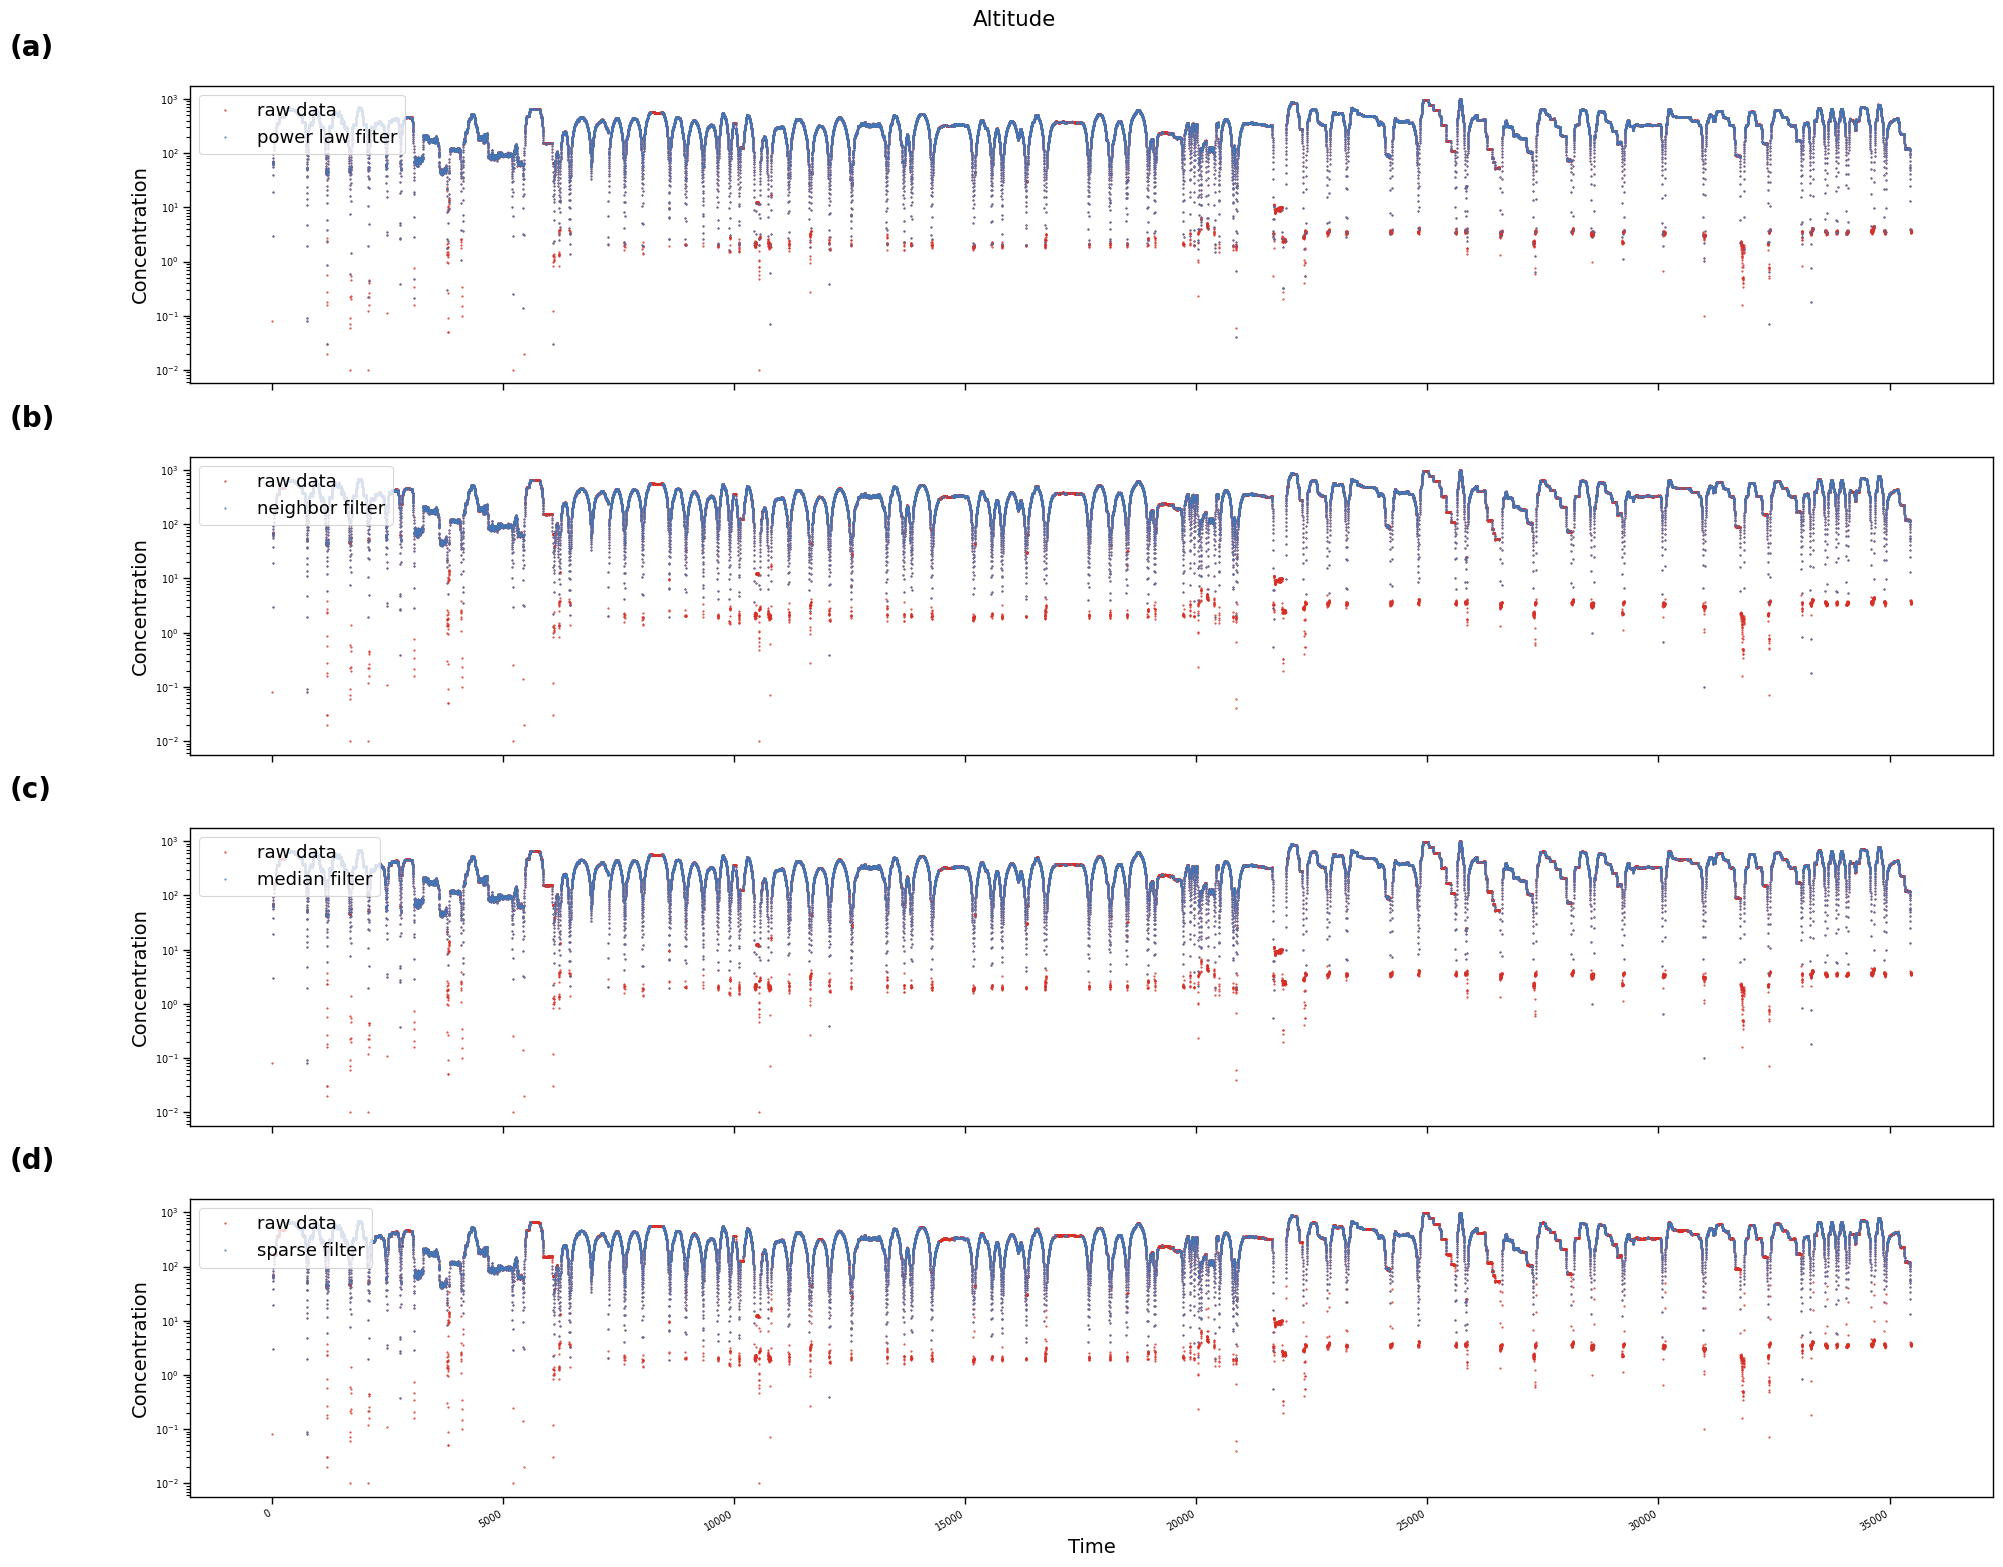

fda parameters used for mCDA_total_N:
{'inverse': False,
 'avg_time': '5s',
 'main_filter': 'power_law',
 'use_neighbor_filter': False,
 'use_median_filter': True,
 'use_sparse_filter': False,
 'pl_a': 2.2,
 'pl_m': 0,
 'iqr_window': None,
 'iqr_factor': None,
 'lower_thr': 0,
 'upper_thr': 1,
 'median_window': '2min',
 'median_factor': 4.0,
 'sparse_window': 30,
 'sparse_thr': 30}
TP = 2546
FP = 129
TN = 5645
FN = 142
Precision = 0.9517757009345794
Recall = 0.9471726190476191
F1 = 0.949468581018087


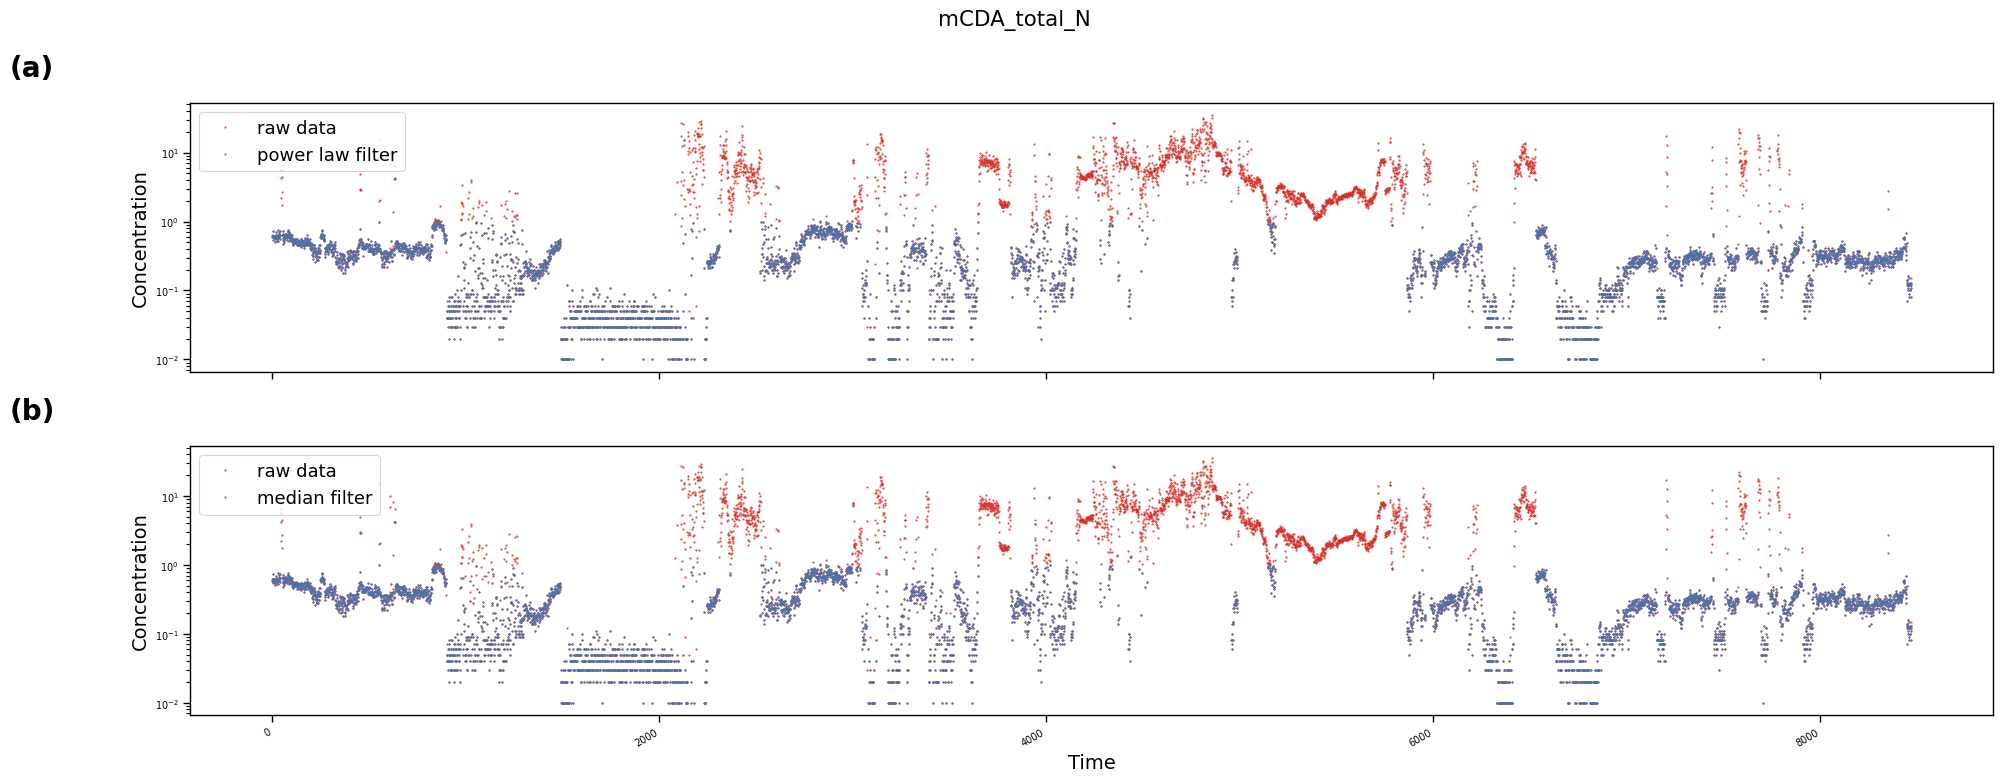

fda parameters used for CPC_total_N:
{'inverse': False,
 'avg_time': '5s',
 'main_filter': 'power_law',
 'use_neighbor_filter': False,
 'use_median_filter': True,
 'use_sparse_filter': False,
 'pl_a': 120,
 'pl_m': 0,
 'iqr_window': None,
 'iqr_factor': None,
 'lower_thr': 0,
 'upper_thr': 4000,
 'median_window': '1min',
 'median_factor': 2.0,
 'sparse_window': 30,
 'sparse_thr': 30}
TP = 66
FP = 188
TN = 9167
FN = 19
Precision = 0.25984251968503935
Recall = 0.7764705882352941
F1 = 0.3893805309734514


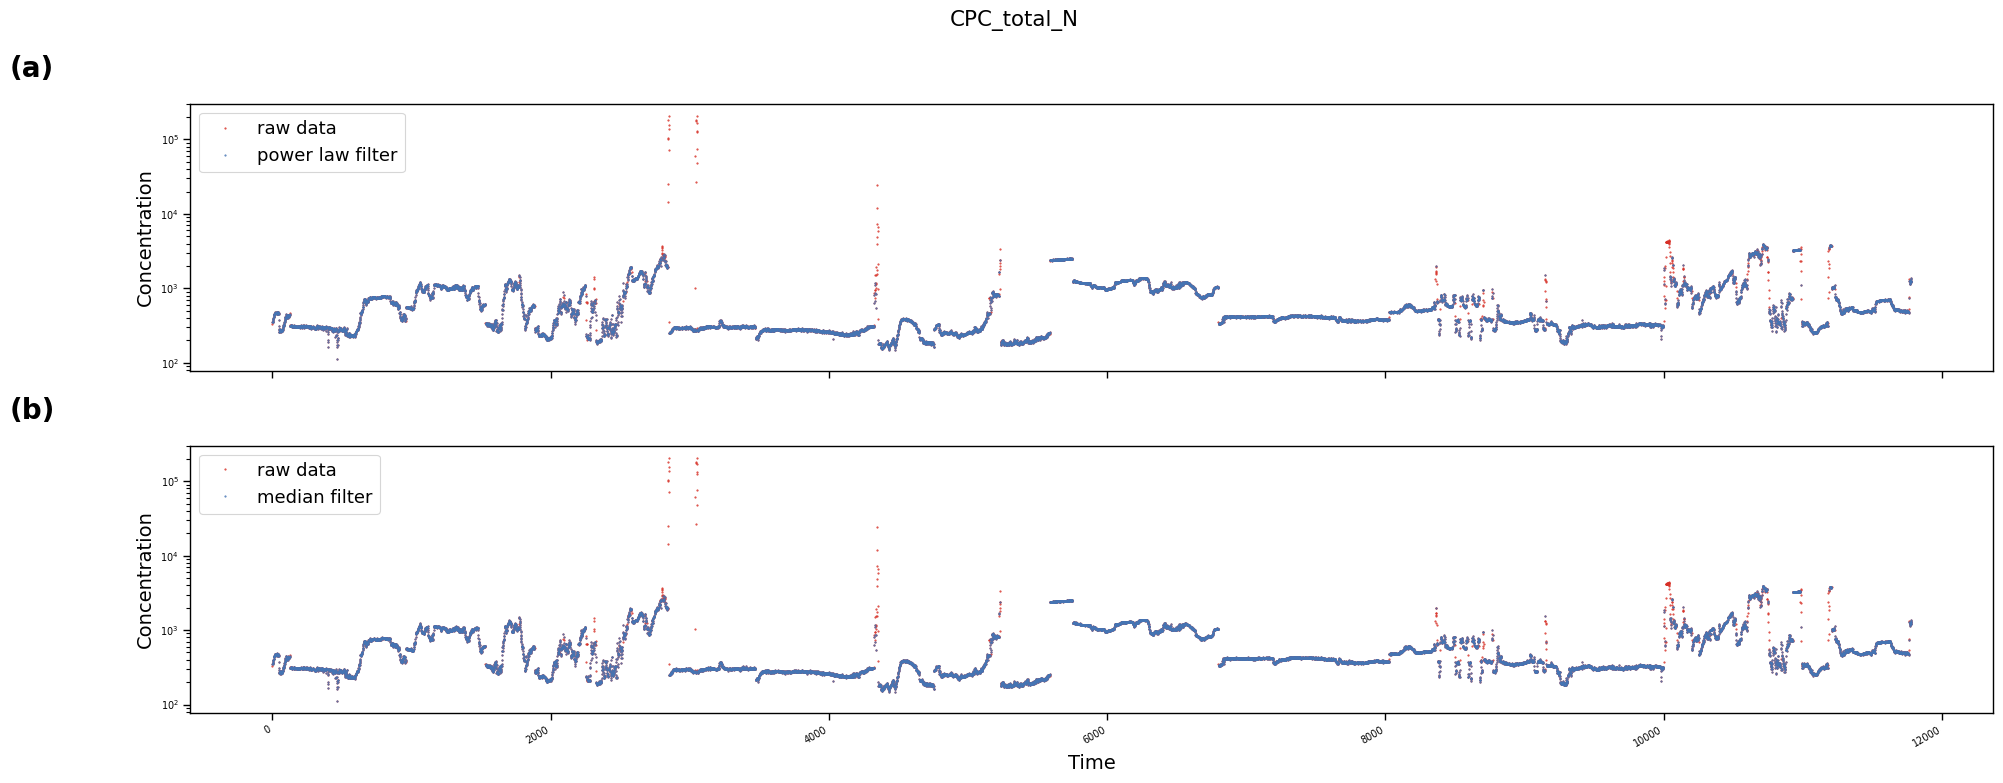

In [13]:
from dataclasses import asdict
from pprint import pprint

for col, flag_col in columns_to_flags.items():
    print(f"fda parameters used for {col}:")
    pprint(asdict(best_params[col]), sort_dicts=False)

    fda = FDA(df, col, flag_col, best_params[col])
    flag = fda.detect_pollution()
    FDA.evaluate(df[col], flag, df[flag_col], verbose=True)
    fda.plot_detection(use_time_index=False, markersize=1, save_path=f"{flag_col}.png")